In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, GroupKFold
from sklearn.model_selection import cross_val_predict

In [2]:
df = pd.read_csv("example_data/psc_all_mz_20240109.csv", index_col=0)
# drop rows that do not have a known stack sequence, which is necessary for us
df = df.dropna(subset="Cell_stack_sequence")
df = df[df["Cell_stack_sequence"] != "Unknown"]
print(df.describe())
print(df.keys())

/tmp/ipykernel_23787/1903257699.py:1: DtypeWarning: Columns (10,17,19,22,23,27,29,31,32,35,36,40,44,45,46,48,51,54,65,66,67,68,69,71,73,74,84,85,86,89,90,93,98,99,100,105,108,113,115,118,122,123,124,125,130,134,138,142,143,144,146,149,152,163,166,167,171,172,173,175,178,181,192,193,194,224,225,255,271,272,273,277,278,304,314,315,321,322,325,326,330,331,335,336,338,342,348,352,355,369,370,371,373,374,376,380,384,387,390,393,403,404,405,406,407,408,409) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("example_data/psc_all_mz_20240109.csv", index_col=0)


        Ref_ID_temp  Cell_area_total  Cell_area_measured  \
count  42888.000000      1096.000000        42154.000000   
mean   20957.837600         0.948353            0.178912   
std    12378.356821         4.568848            0.916653   
min        1.000000         0.007850            0.000120   
25%    10228.750000         0.080000            0.090000   
50%    20954.500000         0.100000            0.100000   
75%    31676.250000         0.160000            0.120000   
max    42404.000000        43.250000           70.000000   

       Cell_number_of_cells_per_substrate  Cell_flexible_min_bending_radius  \
count                        42888.000000                               0.0   
mean                             0.051809                               NaN   
std                              0.655628                               NaN   
min                              0.000000                               NaN   
25%                              0.000000                       

In [3]:
n_rows = len(df)
thresh_frac = 3/10 # fraction of rows to have nan or unknown values
cols_common = []
for col in df:
    n_na = df[col].isna().sum()
    n_unknown = (df[col]=='Unknown').sum()
    if (n_na+n_unknown) < (n_rows*thresh_frac):
        print(f"{col}: #unique values {len(df[col].unique())} ({df[col].dtype}), #NAN {n_na}, #unknown {n_unknown}")
        cols_common.append(col)
print(f"# columns: {len(cols_common)}")

Ref_ID_temp: #unique values 42394 (int64), #NAN 0, #unknown 0
Ref_name_of_person_entering_the_data: #unique values 97 (object), #NAN 40, #unknown 0
Ref_data_entered_by_author: #unique values 2 (bool), #NAN 0, #unknown 0
Ref_DOI_number: #unique values 7427 (object), #NAN 241, #unknown 0
Ref_lead_author: #unique values 1500 (object), #NAN 0, #unknown 0
Ref_publication_date: #unique values 1908 (object), #NAN 0, #unknown 0
Ref_journal: #unique values 339 (object), #NAN 0, #unknown 0
Ref_part_of_initial_dataset: #unique values 2 (bool), #NAN 0, #unknown 0
Ref_original_filename_data_upload: #unique values 34 (object), #NAN 0, #unknown 0
Cell_stack_sequence: #unique values 5541 (object), #NAN 0, #unknown 0
Cell_area_measured: #unique values 506 (float64), #NAN 734, #unknown 0
Cell_number_of_cells_per_substrate: #unique values 12 (float64), #NAN 0, #unknown 0
Cell_architecture: #unique values 7 (object), #NAN 0, #unknown 42
Cell_flexible: #unique values 2 (object), #NAN 0, #unknown 0
Cell_sem

In [13]:
col = "HTL_stack_sequence"
n_na = df[col].isna().sum()
n_unknown = (df[col]=='Unknown').sum()
print("#unknown: ", n_unknown)
print("#NAN: ", n_na)
counts = df[col].value_counts()
print(counts)

#unknown:  86
#NAN:  0
HTL_stack_sequence
Spiro-MeOTAD            20966
PEDOT:PSS                6693
none                     2625
PTAA                     1987
NiO-c                    1700
                        ...  
TPA-QA-TPA                  1
Spiro-MeOTAD | Al2O3        1
Chl‐2                       1
Chl‐1                       1
KR353                       1
Name: count, Length: 1959, dtype: int64


In [62]:
# define the columns we want to use
# columns with lists of categories
cols_cat_list = [
    #"Cell_stack_sequence",
    "ETL_deposition_procedure",
    "Substrate_stack_sequence",
    "ETL_stack_sequence",
    "ETL_deposition_procedure",
    "Perovskite_deposition_solvents",
    "HTL_stack_sequence",
    "HTL_deposition_procedure",
    "Backcontact_stack_sequence",
    "Backcontact_deposition_procedure"]
# columns with single categories
cols_category = [
    "Cell_architecture",
    "Perovskite_deposition_procedure",
    "Perovskite_deposition_aggregation_state_of_reactants"]
# columns with lists of numeric values
cols_num_list = [
    "Perovskite_dimension_list_of_layers",
    "Perovskite_deposition_thermal_annealing_temperature",
    "Perovskite_deposition_thermal_annealing_time"]
# columns that determine the perovskite composition
cols_composition = [
    "Perovskite_composition_a_ions_coefficients",
    "Perovskite_composition_b_ions_coefficients",
    "Perovskite_composition_c_ions_coefficients",
    "Perovskite_composition_a_ions",
    "Perovskite_composition_b_ions",
    "Perovskite_composition_c_ions",
]
# columns with single numeric values
cols_num = ["Cell_area_measured"]
# columns with binary values
cols_bin = [
    "Cell_flexible",
    "Cell_semitransparent",
    "Perovskite_single_crystal",
    "Perovskite_dimension_0D",
    "Perovskite_dimension_2D",
    "Perovskite_dimension_2D3D_mixture",
    "Perovskite_dimension_3D",
    "Perovskite_dimension_3D_with_2D_capping_layer",
    "Perovskite_deposition_quenching_induced_crystallisation",
    "Perovskite_deposition_solvent_annealing",
    "Encapsulation"]
cols_all = [
    *cols_composition,
    *cols_cat_list,
    *cols_category,
    *cols_num_list,
    *cols_num,
    *cols_bin]
print(cols_all)

cols_targets = ["JV_default_Voc", "JV_default_Jsc", "JV_default_PCE"]

['Perovskite_composition_a_ions_coefficients', 'Perovskite_composition_b_ions_coefficients', 'Perovskite_composition_c_ions_coefficients', 'Perovskite_composition_a_ions', 'Perovskite_composition_b_ions', 'Perovskite_composition_c_ions', 'ETL_deposition_procedure', 'Substrate_stack_sequence', 'ETL_stack_sequence', 'ETL_deposition_procedure', 'Perovskite_deposition_solvents', 'HTL_stack_sequence', 'HTL_deposition_procedure', 'Backcontact_stack_sequence', 'Backcontact_deposition_procedure', 'Cell_architecture', 'Perovskite_deposition_procedure', 'Perovskite_deposition_aggregation_state_of_reactants', 'Perovskite_dimension_list_of_layers', 'Perovskite_deposition_thermal_annealing_temperature', 'Perovskite_deposition_thermal_annealing_time', 'Cell_area_measured', 'Cell_flexible', 'Cell_semitransparent', 'Perovskite_single_crystal', 'Perovskite_dimension_0D', 'Perovskite_dimension_2D', 'Perovskite_dimension_2D3D_mixture', 'Perovskite_dimension_3D', 'Perovskite_dimension_3D_with_2D_capping_l

In [63]:
df_in = df[cols_all]#.drop(labels=["Ref_ID_temp"], axis=1)
print(len(df_in))
print(len(df_in.drop_duplicates()))
df_in = df_in.dropna(subset=cols_composition)
print(len(df_in))

42888
17590
42750


In [64]:
def trim_ions_string(ions_string):
    # NOTE: | in the stack string denotes layering, we ignore this and split
    # on compositions (denoted by "; ") and layering agnostically
    return ions_string.replace("; ", " ").replace(" | ", " ").split()

def trim_ions_ratio(ions_ratio_string):
    # NOTE: some strings might have x as a ratio, we replace this as 1
    temp = ions_ratio_string
    ions_ratio_string = ions_ratio_string.replace("x", "1")
    coefficients = ions_ratio_string.replace("; ", " ").replace(" | ", " ").split()
    return [float(coefficient) for coefficient in coefficients]

# function to get composition vectors from dataframe columns with ions and ratios
class CompositionEncoder:
    def __init__(self):
        self.ions_unique = []
        self.n_categories = None

    def fit(self, ions_stack_strings):
        ions_stacks = [trim_ions_string(ions_stack_string) for ions_stack_string in ions_stack_strings]
        self.ions_unique = []
        for ions_stack in ions_stacks:
            for ion in ions_stack:
                self.ions_unique.append(ion)
        self.ions_unique = list(set(self.ions_unique))
        self.n_categories = len(self.ions_unique)

    def transform(self, ions_names, ions_ratios):
        ions_stacks = [trim_ions_string(comp) for comp in ions_names]
        ions_ratios = [trim_ions_ratio(comp) for comp in ions_ratios]

        compositions = []
        for ions, ratios in zip(ions_stacks, ions_ratios):
            composition = np.zeros(self.n_categories)
            indices = [self.ions_unique.index(ion) for ion in ions]
            for index, ratio in zip(indices, ratios):
                composition[index] += ratio
            composition /= np.sum(composition)
            compositions.append(composition)

        return np.vstack(compositions)

df_small = df_in[:]
enc = CompositionEncoder()
enc.fit(df_small["Perovskite_composition_c_ions"].to_list())
print(enc.ions_unique, enc.n_categories)
#enc.fit(df_in["Perovskite_composition_a_ions"].to_list())
compositions = enc.transform(
    df_small["Perovskite_composition_c_ions"],
    df_small["Perovskite_composition_c_ions_coefficients"])
print(compositions, compositions.shape, np.sum(np.isnan(compositions)))
print(max(np.sum(compositions, axis=1)), np.argmax(np.sum(compositions, axis=1)))
        

['F', 'FA', 'MA', '(SCN)', 'Br', 'S', 'I', '(BF4)', '(PF6)', 'Cl', 'O', 'PF6', 'SCN', 'Cs'] 14
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (42750, 14) 0
1.0000000000000002 26568


In [72]:
# prep dataframe
target = "JV_default_PCE"
#target = "JV_default_Voc"
#target = "JV_default_Jsc"
#target = "JV_default_FF"

grouped = df.groupby(
    list(set(cols_all)),
    as_index=False)

agg_dict = {
    target: ["mean", "std"],
    **{col: ["mean", "std"] for col in cols_num},
    **{col: "first" for col in cols_category},
    **{col: "first" for col in cols_cat_list},
    **{col: "first" for col in cols_num_list},
    **{col: "first" for col in cols_bin},
    **{col: "first" for col in cols_composition},
}

df_fit = grouped.agg(agg_dict)
col_names = ['_'.join(col_name).strip().replace("_mean","").replace("_first","") \
    for col_name in df_fit.columns.values]
df_fit.columns = col_names

df_fit = df_fit.dropna(subset=target)

ions_list = []

enc = CompositionEncoder()
enc.fit(
    df_fit["Perovskite_composition_a_ions"].to_list())
comp_a = enc.transform(
    df_fit["Perovskite_composition_a_ions"],
    df_fit["Perovskite_composition_a_ions_coefficients"])
ions_list += [ion+"_a_site_coefficient" for ion in enc.ions_unique]

enc = CompositionEncoder()
enc.fit(
    df_fit["Perovskite_composition_b_ions"].to_list())
comp_b = enc.transform(
    df_fit["Perovskite_composition_b_ions"],
    df_fit["Perovskite_composition_b_ions_coefficients"])
ions_list += [ion+"_b_site_coefficient" for ion in enc.ions_unique]

enc = CompositionEncoder()
enc.fit(
    df_fit["Perovskite_composition_c_ions"].to_list())
comp_c = enc.transform(
    df_fit["Perovskite_composition_c_ions"],
    df_fit["Perovskite_composition_c_ions_coefficients"])
ions_list += [ion+"_c_site_coefficient" for ion in enc.ions_unique]

comp_all = np.concatenate((comp_a, comp_b, comp_c), axis=1)

cols_cat_in = list(set(cols_all) - set(cols_num) - set(cols_composition))

In [70]:
enc = TargetEncoder(smooth="auto")
X = df_fit[cols_cat_in]
y = df_fit[target]
X_trans = enc.fit_transform(X, y)

print(X_trans.shape, y.shape, comp_all.shape)

X_combined = np.concatenate((X_trans, comp_all), axis=1)

regr = RandomForestRegressor(max_depth=100, random_state=0, max_features='sqrt', oob_score=True)
#regr = GradientBoostingRegressor(random_state=0)
cv = KFold(n_splits=5)
scores = cross_validate(regr, X=X_combined, y=y, cv=cv,
    scoring=['r2', 'neg_mean_absolute_error'], n_jobs=-1,
    return_estimator=True, error_score='raise')
print(scores.keys())
print("r^2: ", scores['test_r2'])
print("MAE: ", -1*scores['test_neg_mean_absolute_error'])

print("Average standard deviation of the target: ", df_fit[target+"_std"].mean())

(16937, 25) (16937,) (16937, 178)
dict_keys(['fit_time', 'score_time', 'estimator', 'test_r2', 'test_neg_mean_absolute_error'])
r^2:  [0.36308813 0.36317844 0.36184275 0.37223046 0.46537734]
MAE:  [2.91787036 3.0856178  3.04374618 3.1157991  3.0716558 ]
Average standard deviation of the target:  1.6315470961060987


In [73]:
features = cols_cat_in + ions_list
print(features)
importances = None
for idx, estimator in enumerate(scores["estimator"]):
    importance = estimator.feature_importances_
    if idx==0:
        importances = importance
    else:
        importances = np.vstack((importances, importance))
    #sort_indices = np.argsort(-1*importance)
    #print(importance[sort_indices[:10]])
    #print(np.array(features)[sort_indices[:10]])

n_features_show = 10
importance_avg = np.mean(importances, axis=0)
importance_std = np.std(importances, axis=0)
sort_indices = np.argsort(-1*importance_avg)
for i in range(n_features_show):
    print(np.array(features)[sort_indices[i]], importance_avg[sort_indices[i]],
        importance_std[sort_indices[i]])

['HTL_deposition_procedure', 'Perovskite_dimension_0D', 'Perovskite_deposition_procedure', 'Backcontact_stack_sequence', 'Cell_architecture', 'Perovskite_dimension_3D_with_2D_capping_layer', 'Perovskite_deposition_solvents', 'Perovskite_deposition_thermal_annealing_temperature', 'Perovskite_dimension_2D', 'Cell_semitransparent', 'Perovskite_deposition_solvent_annealing', 'Cell_flexible', 'Perovskite_single_crystal', 'Encapsulation', 'Substrate_stack_sequence', 'Backcontact_deposition_procedure', 'Perovskite_dimension_2D3D_mixture', 'Perovskite_deposition_quenching_induced_crystallisation', 'Perovskite_deposition_thermal_annealing_time', 'ETL_stack_sequence', 'Perovskite_dimension_list_of_layers', 'ETL_deposition_procedure', 'Perovskite_deposition_aggregation_state_of_reactants', 'Perovskite_dimension_3D', 'HTL_stack_sequence', '(TBA)_a_site_coefficient', '(pFPEA)_a_site_coefficient', 'GU_a_site_coefficient', '(3AMP)_a_site_coefficient', 'La_a_site_coefficient', 'Na_a_site_coefficient',

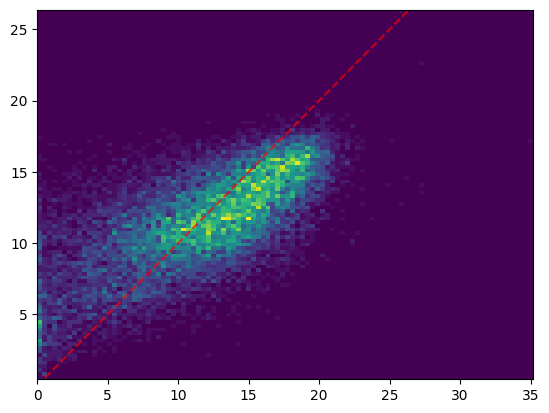

In [45]:
y_pred = cross_val_predict(regr, X=X_combined, y=y, cv=cv)

fig, ax = plt.subplots()
ax.hist2d(y, y_pred, bins=100)
x_ref = np.linspace(*ax.get_xlim())
ax.plot(x_ref, x_ref, '--', alpha=0.7, color='red')

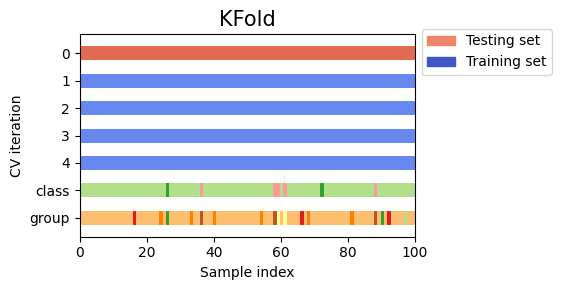

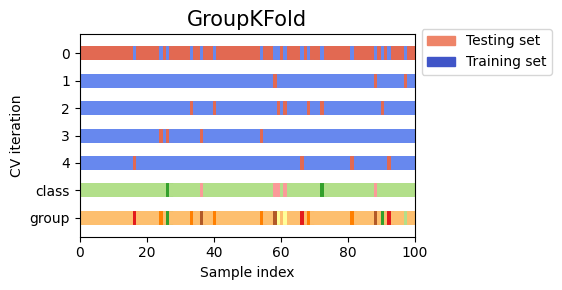

In [9]:
from matplotlib.patches import Patch

cvs = [KFold, GroupKFold]
X = np.array(list(df_fit['composition']))
y = np.array(df_fit[target_name])
groups = df_fit["composition"].astype(str).astype('category').cat.codes
n_splits = 5
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

plt.show()

In [10]:
oob_scores = [estimator.oob_score_ for estimator in scores['estimator']]
print(oob_scores)

[0.9083475773238742, 0.8794888060406558, 0.8590292091024202, 0.8791415062810186, 0.8621514534400385]


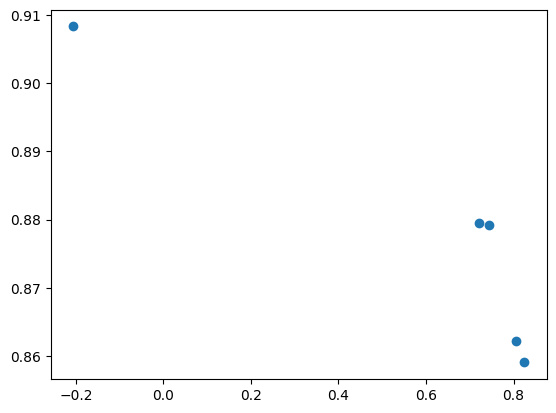

In [11]:
import matplotlib.pyplot as plt

#preds = regr.predict(comp_array)
plt.scatter(scores['test_r2'], oob_scores)
plt.show()

In [35]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

cols = [
    "substrate", "electron_transport_layer", "hole_transport_layer",
    "back_contact", "absorber_fabrication", "chemical_formula_descriptive"]
enc = OneHotEncoder(sparse=True) # change keyword to sparse_output for sklearn version 1.2 or later
enc.fit(df[cols])
one_hot_features = enc.transform(df[cols])
print(enc.categories_[1])
print(one_hot_features)
print(sum(one_hot_features[0]))
print(one_hot_features.shape)
print("number of NaN values: ", np.sum(np.isnan(one_hot_features)))

["['(2Z,2′Z)-3,3′- (5,5′-(2,7-dioctyl-1,3,6,8-tetraoxo-1,2,3,6,7,8-hexahydrobenzo [lmn][3,8]phenanthroline-4,9-diyl)bis (thiophene-5,2-diyl))bis(2-(4-(trifluoromethyl)phenyl) acrylonitrile)']"
 "['(2Z,2′Z)-3,3′-(5,5′-(2,7-dioctyl-1,3,6,8-tetraoxo-1,2,3,6,7,8-hexahydrobenzo[lmn][3,8] phenanthroline-4,9-diyl)bis(thiophene-5,2-diyl))bis(2-(3,5-bis (trifluoroomethyl)phenyl) acrylonitrile)']"
 "['(4AMP)I2', 'PCBM-60', 'BCP']" ... "['t-BPTI', 'C60', 'BCP']"
 "['t-BPTI', 'PDI-C4', 'BCP']" "['tris-PCBOE', 'ZnO']"]
  (0, 136)	1.0
  (0, 716)	1.0
  (0, 2856)	1.0
  (0, 3656)	1.0
  (0, 3933)	1.0
  (0, 6038)	1.0
  (1, 136)	1.0
  (1, 669)	1.0
  (1, 2890)	1.0
  (1, 3656)	1.0
  (1, 4096)	1.0
  (1, 6038)	1.0
  (2, 128)	1.0
  (2, 1364)	1.0
  (2, 3596)	1.0
  (2, 3686)	1.0
  (2, 4096)	1.0
  (2, 6038)	1.0
  (3, 136)	1.0
  (3, 669)	1.0
  (3, 2890)	1.0
  (3, 3656)	1.0
  (3, 4096)	1.0
  (3, 6038)	1.0
  (4, 128)	1.0
  :	:
  (43095, 6038)	1.0
  (43096, 128)	1.0
  (43096, 1364)	1.0
  (43096, 3201)	1.0
  (43096, 3

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [24]:
!pip3 show scikit-learn

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Name: scikit-learn
Version: 1.0.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /users/stud/bechtelt/.local/lib/python3.7/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: sklearn, spektral


In [38]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, n_iter=100, random_state=42)
svd.fit(one_hot_features)

TruncatedSVD(n_components=5, n_iter=100, random_state=42)

[0.0579973  0.18345354 0.07667129 0.06529849 0.05742363]
number of NaN values:  0


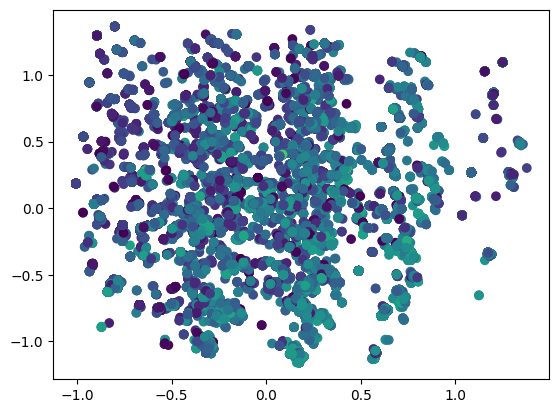

In [42]:
print(svd.explained_variance_ratio_)
transformed_features = svd.transform(one_hot_features)
print("number of NaN values: ", np.sum(np.isnan(transformed_features)))
plt.scatter(transformed_features[:, 4], transformed_features[:, 2], c=df['efficiency'])
plt.show()

In [47]:
regr = RandomForestRegressor(max_depth=100, random_state=0, max_features='sqrt',
    oob_score=True)
#regr = SVR()
cv = KFold(n_splits=5)
invalid = np.isnan(df['band_gap'])
targets = df['band_gap'][~invalid]
inputs = transformed_features[~invalid]
scores = cross_validate(regr, X=inputs, y=targets, cv=cv,
    scoring=['r2', 'neg_mean_absolute_error'], n_jobs=-1, return_estimator=True, error_score='raise')
print(scores.keys())
print(scores['test_r2'])
print(-1*scores['test_neg_mean_absolute_error'])

dict_keys(['fit_time', 'score_time', 'estimator', 'test_r2', 'test_neg_mean_absolute_error'])
[0.71659041 0.75178267 0.72124311 0.73534414 0.72138611]
[0.01925203 0.01876639 0.01953322 0.01841769 0.01858999]


In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#from transformations import one_hot_encode_column
def one_hot_encode_column(col: pd.Series, return_classes=False):
    col_array = col.to_numpy()
    col_array = col_array.reshape((len(col), 1))
    enc = OneHotEncoder(sparse=False)
    enc.fit(col_array)
    
    if return_classes:
        return enc.transform(col_array), list(enc.categories_)
    else:
        return enc.transform(col_array)

etl_oh = one_hot_encode_column(df_common["electron_transport_layer"])
print(etl_oh)
print(np.sum(etl_oh))
print(etl_oh.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
41110.0
(41110, 983)


In [80]:
vals = []
max_len = 0
arr = np.zeros((0,1))
elt_list = []

for i, val in enumerate(df_common["absorber_fabrication"]):
    converted = val.replace('[', '').replace(']', '').replace("'", '')
    split = converted.split(', ')
    #print(split)
    elt_list.append(split)
    if len(split) > max_len:
        max_len = len(split)
        print(split)
    for layer in split:
        vals.append(layer)
print("Number of unique sub-layers: ", len(set(vals)))
print("Number of rows: ", len(elt_list))

print(arr)
print("Most sub-layers in single layer: ", max_len)

['Spin-coating']
['Spin-coating', 'Spin-coating']
['Spin-coating', 'Spin-coating >> IPA washing', 'Spin-coating >> IPA washing']
['Spin-coating', 'Spin-coating >> IPA washing', 'Spin-coating >> IPA washing', 'Spin-coating >> IPA washing']
Number of unique sub-layers:  185
Number of rows:  41110
[]
Most sub-layers in single layer:  4


In [81]:
enc = OneHotEncoder(sparse=False)
vals_arr = np.array(vals).reshape((-1, 1))
enc.fit(vals_arr)
print("Number of categories: ", len(enc.categories_[0]))

layers_encoded = []
for i, layer in enumerate(elt_list):
    encoding = enc.transform(np.array(layer).reshape(-1, 1))
    encoding = np.sum(encoding, axis=0)/np.sum(encoding)
    layers_encoded.append(encoding)
    
layers_encoded = np.array(layers_encoded)
print(layers_encoded.shape)
print(np.sum(layers_encoded))


Number of categories:  185
(41110, 185)
41110.0


In [8]:
cols = [
    "substrate", "electron_transport_layer", "hole_transport_layer",
    "back_contact", "absorber_fabrication"]
cols_encoded = []

for col in cols:
    print("Column name: ", col)
    sub_layers = []
    layers = []

    for i, val in enumerate(df_common[col]):
        converted = val.replace('[', '').replace(']', '').replace("'", '')
        split = converted.split(', ')
        layers.append(split)
        for layer in split:
            sub_layers.append(layer)

    enc = OneHotEncoder(sparse=False)
    sub_layers = np.array(sub_layers).reshape((-1, 1))
    enc.fit(sub_layers)
    print("Number of categories: ", len(enc.categories_[0]))

    layers_encoded = []
    for i, layer in enumerate(layers):
        encoding = enc.transform(np.array(layer).reshape(-1, 1))
        encoding = np.sum(encoding, axis=0)/np.sum(encoding)
        layers_encoded.append(encoding)
        
    layers_encoded = np.array(layers_encoded)
    print("Column shape: ", layers_encoded.shape)
    cols_encoded.append(layers_encoded)

Column name:  substrate
Number of categories:  81
Column shape:  (41110, 81)
Column name:  electron_transport_layer
Number of categories:  628
Column shape:  (41110, 628)
Column name:  hole_transport_layer
Number of categories:  876
Column shape:  (41110, 876)
Column name:  back_contact
Number of categories:  132
Column shape:  (41110, 132)
Column name:  absorber_fabrication
Number of categories:  185
Column shape:  (41110, 185)


In [5]:
from transformations import get_compositions_vector_column

comp_array = get_compositions_vector_column(df_common)

print(comp_array)
print(comp_array[0])
print(comp_array.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.07692308 0.         ... 0.         0.         0.        ]]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.08333333 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.25
 0.         0.08333333 0.         0.08333333 0.         0.
 0.5        0.         0.         0.         0.         0.        ]
(41110, 42)


In [9]:
features = np.concatenate(cols_encoded, axis=1)
features = np.concatenate((features, comp_array), axis=1)
print("Shape of feature array: ", features.shape)

u_mat, s_mat, vh_mat = np.linalg.svd(features)

Shape of feature array:  (41110, 1944)


(41110, 41110)
(1944,)
(1944, 1944)


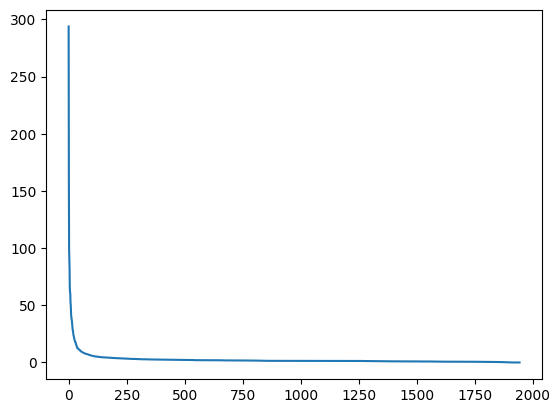

In [10]:
print(u_mat.shape)
print(s_mat.shape)
print(vh_mat.shape)
plt.plot(s_mat)
#plt.yscale('log')
plt.show()


In [11]:
u, s, vh = u_mat, s_mat, vh_mat
k = 10
u[:, :k] * s[:k]
features_reconstructed = np.dot(u[:, :k] * s[:k], vh[:k][:k])
np.allclose(features, features_reconstructed)

False

In [12]:
from sklearn.manifold import TSNE

features_embedded = TSNE().fit_transform(features_reconstructed)

/users/stud/bechtelt/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/users/stud/bechtelt/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(41110, 2)


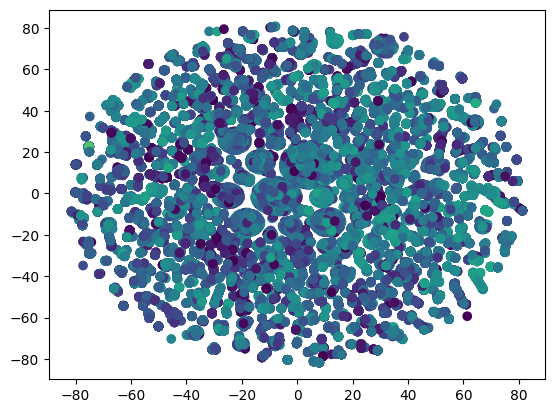

In [13]:
print(features_embedded.shape)
plt.scatter(features_embedded[:, 0], features_embedded[:, 1], c=df_common['efficiency'])
plt.show()

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, GroupKFold


print('Number of samples: ', len(df_common))
# test for nan values
df_fit = pd.DataFrame({})
df_fit['target'] = df_common['band_gap']
df_fit['feature'] = pd.Series(list(features))
df_fit = df_fit.dropna()
targets = np.array(df_fit['target'])
features = np.array(df_fit['feature'])
print(features)

regr = RandomForestRegressor(max_depth=100, random_state=0, max_features='sqrt',
    oob_score=True)
#regr = SVR()
cv = KFold(n_splits=5)
scores = cross_validate(regr, X=features, y=targets, cv=cv,
    scoring=['r2', 'neg_mean_absolute_error'], n_jobs=-1, return_estimator=True)
print(scores.keys())
print(scores['test_r2'])
print(-1*scores['test_neg_mean_absolute_error'])

Number of samples:  41110
[array([0., 0., 0., ..., 0., 0., 0.]) array([0., 0., 0., ..., 0., 0., 0.])
 array([0., 0., 0., ..., 0., 0., 0.]) ...
 array([0., 0., 0., ..., 0., 0., 0.]) array([0., 0., 0., ..., 0., 0., 0.])
 array([0., 0., 0., ..., 0., 0., 0.])]
dict_keys(['fit_time', 'score_time', 'estimator', 'test_r2', 'test_neg_mean_absolute_error'])
[nan nan nan nan nan]
[nan nan nan nan nan]


/users/stud/bechtelt/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/users/stud/bechtelt/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/users/stud/bechtelt/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 328, in fit
    X, y, multi_output=True, accept_spar